<a href="https://colab.research.google.com/github/JackSeiberlich/systematic-trading-backtest/blob/main/backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BackTesting

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from google.colab import files
uploaded = files.upload()  # Select prices.csv from your file system


Saving prices.csv to prices.csv


In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("prices.csv", parse_dates=["Date"], index_col="Date")


Saving prices.csv to prices (1).csv


In [7]:
df.rename(columns={"Price": "Close"}, inplace=True)


In [8]:
def sma_crossover_signals(df, short_window=20, long_window=50):
    df = df.copy()
    df["SMA_short"] = df["Close"].rolling(window=short_window).mean()
    df["SMA_long"] = df["Close"].rolling(window=long_window).mean()
    df["Signal"] = 0
    df["Signal"] = (df["SMA_short"] > df["SMA_long"]).astype(int)
    df["Position"] = df["Signal"].diff()
    return df

df = sma_crossover_signals(df)
df.tail()


,Close,Open,High,Low,Vol.,Change %,SMA_short,SMA_long,Signal,Position
Date,,,,,,,,,,
2018-08-13,282.10,283.47,284.16,281.77,65.73M,-0.37%,287.1435,286.5934,1,0.0
2018-08-10,283.16,283.45,284.06,282.36,77.08M,-0.67%,286.8965,286.7564,1,0.0
2018-08-09,285.07,285.53,285.97,284.92,35.72M,-0.14%,286.7700,286.9328,0,-1.0
2018-08-08,285.46,285.39,285.91,284.94,42.11M,-0.04%,286.6350,287.1140,0,0.0
2018-08-07,285.58,285.39,286.01,285.24,43.20M,0.33%,286.4625,287.2166,0,0.0


In [9]:
df = sma_crossover_signals(df)
df.tail()


,Close,Open,High,Low,Vol.,Change %,SMA_short,SMA_long,Signal,Position
Date,,,,,,,,,,
2018-08-13,282.10,283.47,284.16,281.77,65.73M,-0.37%,287.1435,286.5934,1,0.0
2018-08-10,283.16,283.45,284.06,282.36,77.08M,-0.67%,286.8965,286.7564,1,0.0
2018-08-09,285.07,285.53,285.97,284.92,35.72M,-0.14%,286.7700,286.9328,0,-1.0
2018-08-08,285.46,285.39,285.91,284.94,42.11M,-0.04%,286.6350,287.1140,0,0.0
2018-08-07,285.58,285.39,286.01,285.24,43.20M,0.33%,286.4625,287.2166,0,0.0


In [10]:
df["Market Return"] = df["Close"].pct_change()
df["Strategy Return"] = df["Market Return"] * df["Signal"].shift(1)


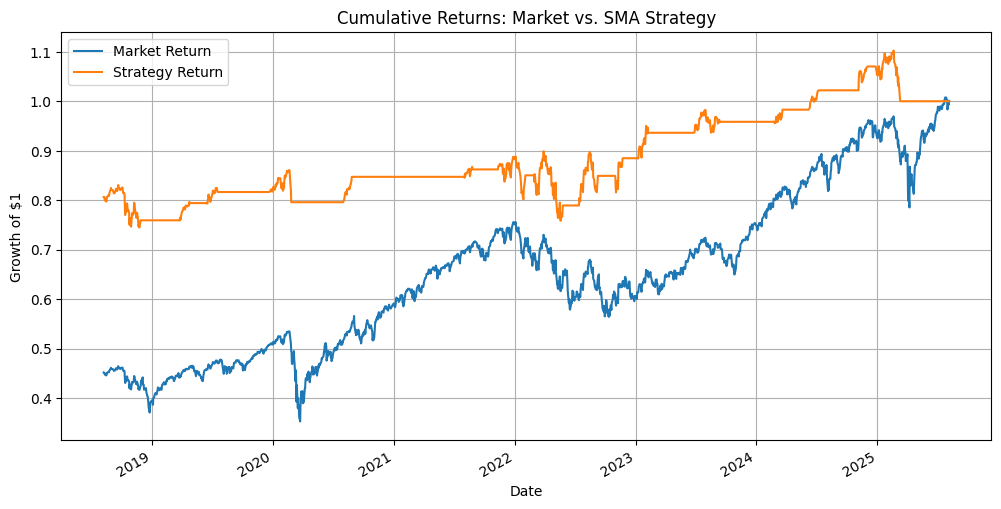

In [11]:
import matplotlib.pyplot as plt

(1 + df[["Market Return", "Strategy Return"]]).cumprod().plot(figsize=(12,6))
plt.title("Cumulative Returns: Market vs. SMA Strategy")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.show()


In [12]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess = returns - risk_free_rate
    return (excess.mean() / excess.std()) * (252 ** 0.5)

sharpe = sharpe_ratio(df["Strategy Return"].dropna())
print(f"Sharpe Ratio: {sharpe:.2f}")


Sharpe Ratio: -0.28


In [13]:
best_sharpe = -float("inf")
best_params = (0, 0)

for short in range(5, 50, 5):           # Try short SMAs from 5 to 45
    for long in range(short + 5, 100, 5):  # Long SMAs must be > short
        temp_df = sma_crossover_signals(df, short_window=short, long_window=long)
        temp_df["Market Return"] = temp_df["Close"].pct_change()
        temp_df["Strategy Return"] = temp_df["Market Return"] * temp_df["Signal"].shift(1)

        sr = sharpe_ratio(temp_df["Strategy Return"].dropna())

        if sr > best_sharpe:
            best_sharpe = sr
            best_params = (short, long)

print(f"Best Sharpe: {best_sharpe:.2f} at short={best_params[0]}, long={best_params[1]}")


Best Sharpe: 0.18 at short=5, long=20


In [14]:
# Rebuild with optimized SMA values
df = sma_crossover_signals(df, short_window=5, long_window=20)

# Recalculate returns
df["Market Return"] = df["Close"].pct_change()
df["Strategy Return"] = df["Market Return"] * df["Signal"].shift(1)


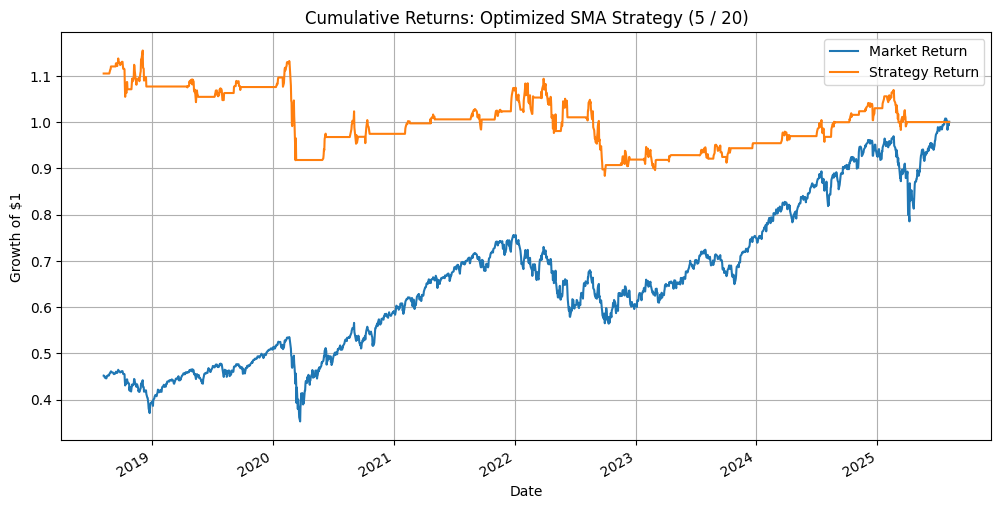

In [15]:
import matplotlib.pyplot as plt

(1 + df[["Market Return", "Strategy Return"]]).cumprod().plot(figsize=(12,6))
plt.title("Cumulative Returns: Optimized SMA Strategy (5 / 20)")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.show()


In [16]:
sharpe = sharpe_ratio(df["Strategy Return"].dropna())
print(f"Sharpe Ratio (5/20): {sharpe:.2f}")


Sharpe Ratio (5/20): 0.18
